In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
from libcomcat.search import count, get_event_by_id, search
import pandas as pd
import numpy as np
import seaborn as sns
import os

fatal: bad revision 'HEAD'


In [2]:
extracted_path = '/data/linhang/workbench/Tipping_points_predictor/data/'

file_name = os.listdir(extracted_path)
print(file_name)

FileNotFoundError: [Errno 2] No such file or directory: '/data/linhang/workbench/Tipping_points_predictor/data/'

In [3]:
lat_min, lat_max = 32, 36
lon_min, lon_max = -120.0, -114.0
lat_step, lon_step = 0.1, 0.1
lat_bins = np.around(np.linspace(lat_min, lat_max, 41),2)
lon_bins = np.around(np.linspace(lon_min, lon_max, 61),2)

In [17]:
grid_counts = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))
grid_ids = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))
for i, lat in enumerate(lat_bins[:-1]):
    for j, lon in enumerate(lon_bins[:-1]):
        lat = np.around(lat, 2)
        lon = np.around(lon, 2)
        file_path = os.path.join("grid_data", f'grid_{lat}_{lon}.csv')
        if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
            try:
                df = pd.read_csv(file_path)
                grid_ids[i, j] = df['Location_id'][0]
                grid_counts[i, j] = len(df)
            except pd.errors.EmptyDataError:
                grid_counts[i, j] = 0
        else:
            grid_counts[i, j] = 0

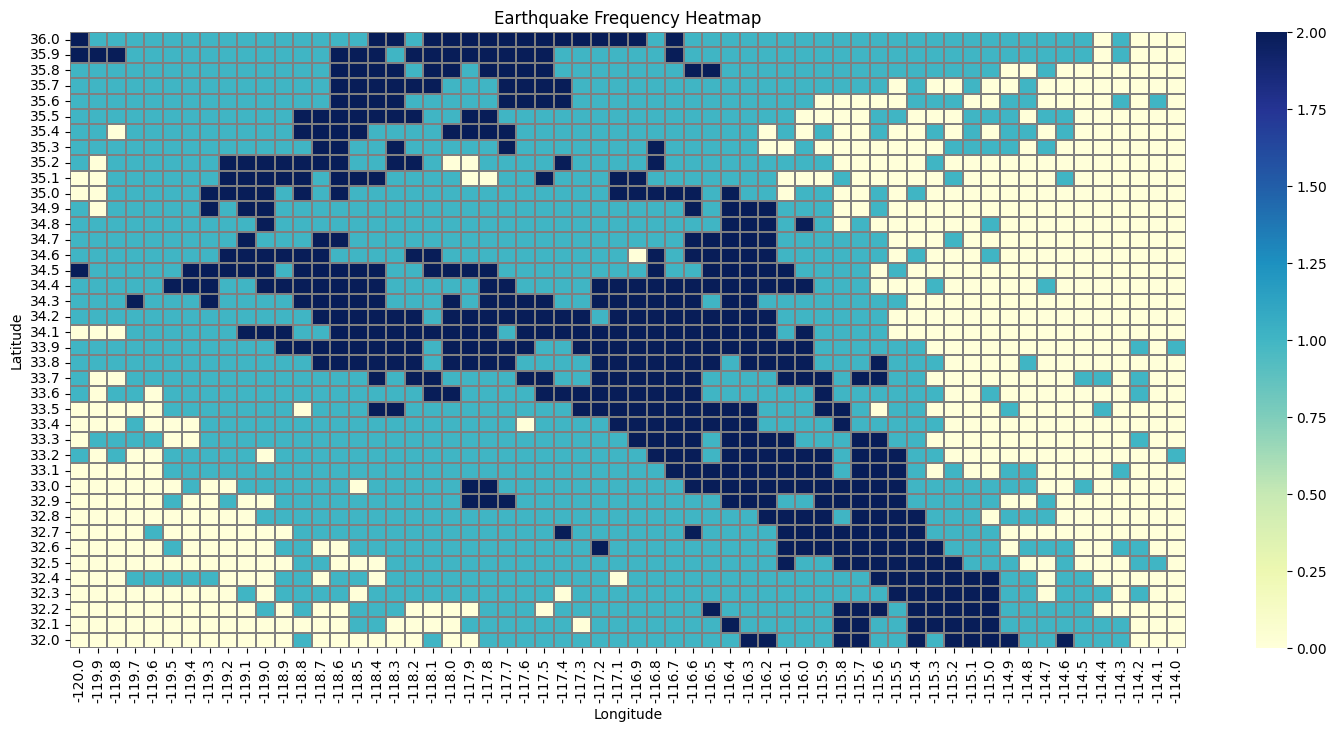

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
plot_data = np.full_like(grid_counts, fill_value=0, dtype=int)
plot_data[grid_counts > 0] = 1
plot_data[grid_counts >= np.sort(grid_counts.flatten())[::-1][499]] = 2

plt.figure(figsize=(18, 8))
sns.heatmap(plot_data, cmap="YlGnBu", xticklabels=np.around(np.linspace(-120, -114, 60), 1), 
            yticklabels=np.around(np.linspace(32, 36, 40), 1), linecolor='grey', linewidths=0.01)

plt.gca().invert_yaxis()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Earthquake Frequency Heatmap')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
plot_data = np.full_like(grid_counts, fill_value=0, dtype=int)
plot_data[grid_counts > 0] = 1
plot_data[grid_counts >= np.sort(grid_counts.flatten())[::-1][499]] = 2

plt.figure(figsize=(18, 8))
sns.heatmap(plot_data, cmap="YlGnBu", xticklabels=np.around(np.linspace(-120, -114, 60), 1), 
            yticklabels=np.around(np.linspace(32, 36, 40), 1), linecolor='grey', linewidths=0.01)

plt.gca().invert_yaxis()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Earthquake Frequency Heatmap')
plt.show()

In [6]:
import pickle
station_dict = pickle.load(open('/data/linhang/workbench/Tipping_points_predictor/station_dict/station_dict_use.pkl', 'rb'))
use_dict = {}
for key in station_dict.keys():
    lat, lon = station_dict[key]
    lat = np.around((lat), 2)
    lon = np.around((lon), 2)
    if lat < lat_min or lat > lat_max or lon < lon_min or lon > lon_max:
        continue
    else:
        use_dict[key] = (lat, lon)
print(len(use_dict))

402


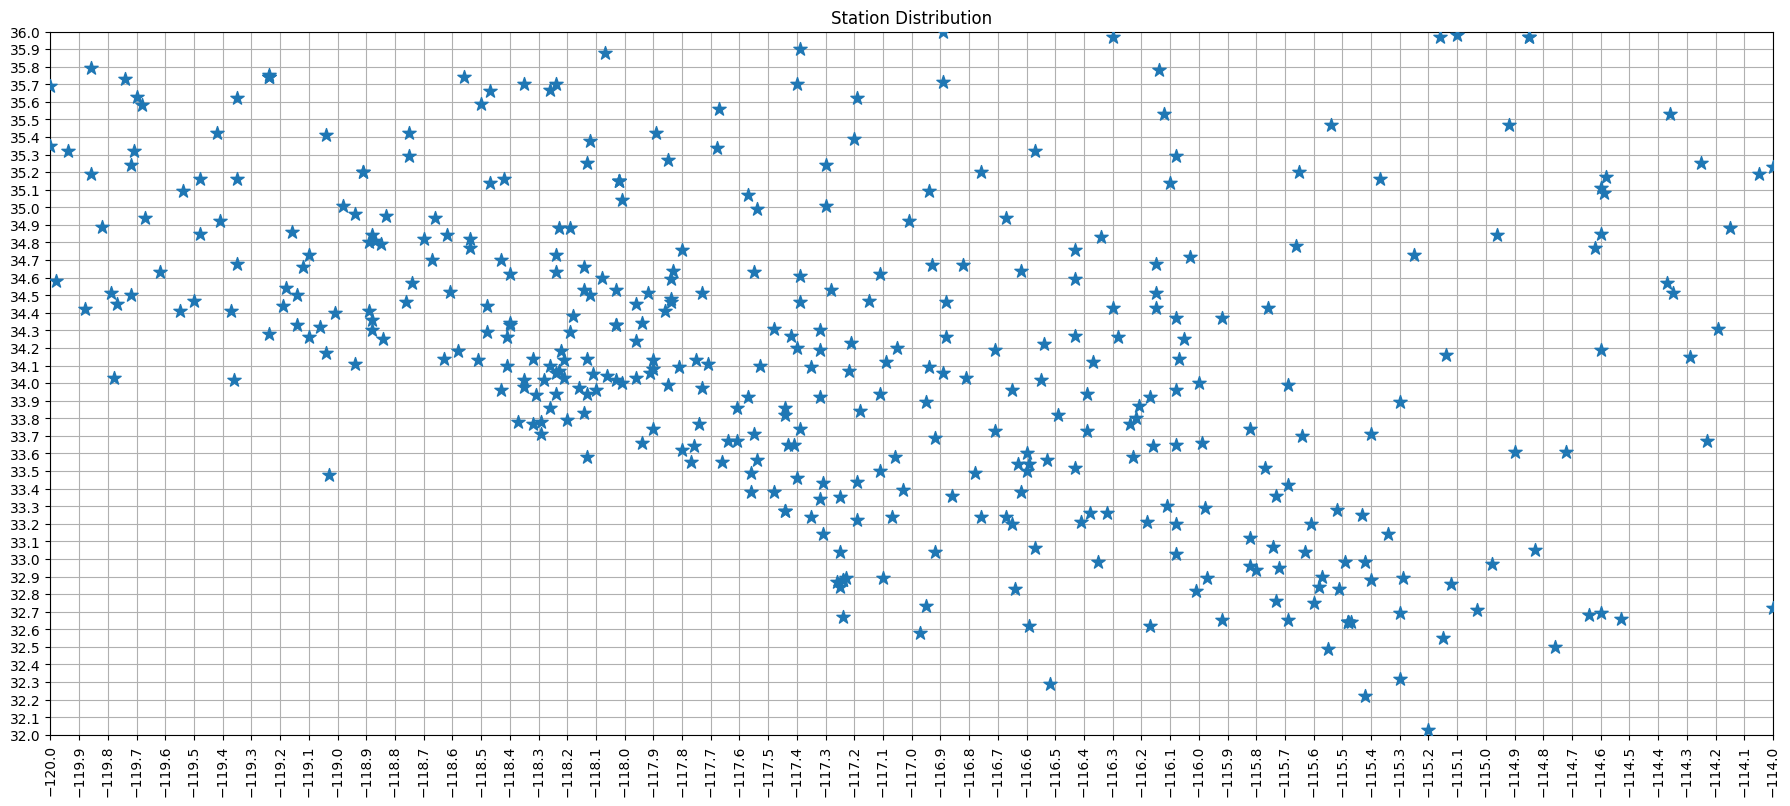

In [7]:
plt.figure(figsize=(18, 8))
plt.scatter([lon for lat, lon in use_dict.values()], [lat for lat, lon in use_dict.values()], s=100, zorder=10, marker='*')
plt.xticks(np.around(np.linspace(-120, -114, 61), 1),rotation=90)
plt.yticks(np.around(np.linspace(32, 36, 41), 1))
plt.xlim(-120, -114)
plt.ylim(32, 36)
plt.grid(True)
plt.tight_layout()
plt.title('Station Distribution')
plt.show()

In [8]:
with open('station_dict_use.pkl', 'wb') as f:
    pickle.dump(use_dict, f)

In [39]:
import pandas as pd
import numpy as np

data = pd.read_csv("/data/linhang/workbench/Tipping_points_predictor/grid_data/grid_33.9_-116.4.csv")
data['Time'] = pd.to_datetime(data['Time'], format='ISO8601', errors='coerce')

data.set_index('Time', inplace=True)
data = data.dropna(subset=['Magnitude'])

start_date = pd.Timestamp('1986-01-01', tz='UTC')
end_date = pd.Timestamp('2024-01-01', tz='UTC')
time_bins = pd.date_range(start=start_date, end=end_date, freq='2W')

data['Time_bin'] = pd.cut(data.index, bins=time_bins, right=True)

def calculate_energy_and_mark(group, threshold=4.0):
    energy = np.sum(10 ** (1.5 * group['Magnitude']))
    max_magnitude = group['Magnitude'].max() if (group['Magnitude'] > threshold).any() else 0
    return pd.Series({'Energy': energy, 'Max_Magnitude': max_magnitude})

grouped = data.groupby('Time_bin', observed=False).apply(lambda x: calculate_energy_and_mark(x))

log_energy = ((1/1.5) * np.log10(grouped['Energy'].replace(0, np.nan))).replace(np.nan, 0)

log_energy_filled = log_energy.reindex(time_bins[:-1], fill_value=0)
max_magnitude_filled = grouped['Max_Magnitude'].reindex(time_bins[:-1], fill_value=0)

result = pd.DataFrame({'Log_Energy': log_energy_filled, 'Max_Magnitude': max_magnitude_filled})

# 结果
print(result.head())

                           Log_Energy  Max_Magnitude
1986-01-05 00:00:00+00:00        0.00            0.0
1986-01-19 00:00:00+00:00        1.49            0.0
1986-02-02 00:00:00+00:00        0.00            0.0
1986-02-16 00:00:00+00:00        0.00            0.0
1986-03-02 00:00:00+00:00        1.46            0.0


/tmp/ipykernel_92456/744979647.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = data.groupby('Time_bin', observed=False).apply(lambda x: calculate_energy_and_mark(x))


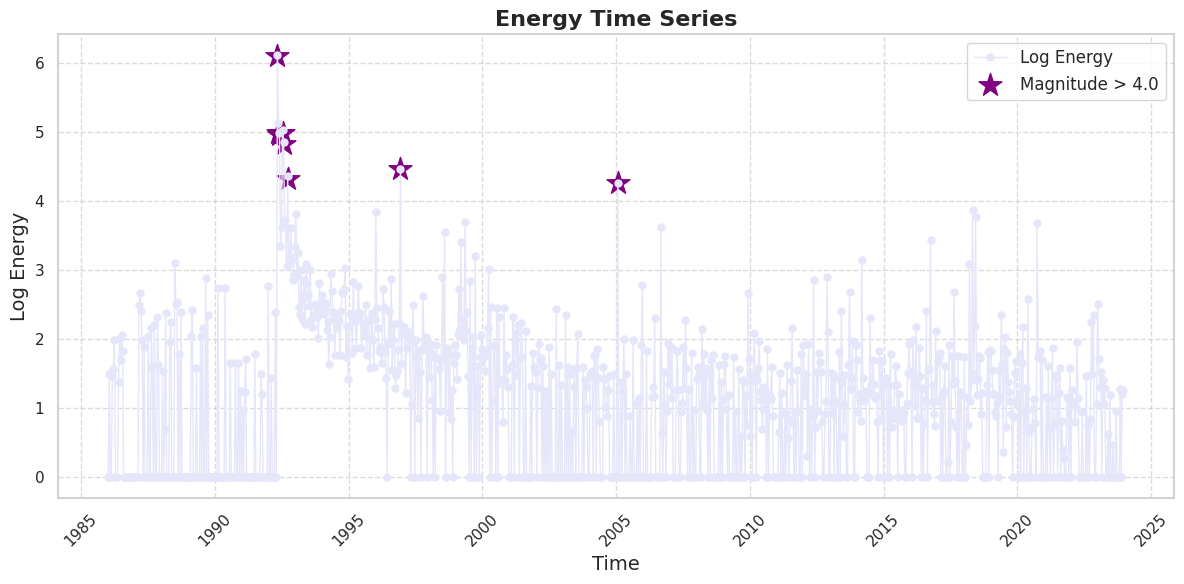

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置Seaborn样式
sns.set(style="whitegrid")

# 创建图表
plt.figure(figsize=(12, 6))

# 绘制对数能量
plt.plot(log_energy_filled.index, log_energy_filled, marker='o', label='Log Energy', markersize=5, color='#E6E6FA', linewidth=1)

plt.scatter(log_energy_filled.index[max_magnitude_filled > 0], max_magnitude_filled[max_magnitude_filled > 0], 
            color='purple', label='Magnitude > 4.0', marker='*', s=300)
plt.title('Energy Time Series', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Log Energy', fontsize=14)
plt.legend(fontsize=12)

plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图表
plt.tight_layout()
plt.show()